# Surface temperature maps in THAI simulations

In [1]:
import matplotlib.colors as mcol
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.offsetbox import AnchoredText

In [2]:
import aeolus.plot as aplt

In [3]:
# Local modules
import mypaths
from calc import (
    sfc_temp,
    meridional_mean,
    spatial_mean,
)
from commons import MODELS
from names import names
from plot_func import (
    KW_AUX_TTL,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    XLOCS,
    darr_stats_string,
    draw_scalar,
    figsave,
    make_map_figure,
    set_alpha_in_cmap,
)

In [4]:
plt.style.use("paper.mplstyle")

## Choose case

In [5]:
THAI_cases = ["Hab1", "Hab2"]

## Load the data

Load the time-averaged data previously preprocessed.

In [6]:
# Load data
datasets = {}  # Create an empty dictionary to store all data
# for each of the THAI cases, create a nested directory for models
for THAI_case in THAI_cases:
    datasets[THAI_case] = {}
    for model_key in MODELS.keys():
        model_names = names[model_key]
        ds = xr.open_dataset(mypaths.datadir / model_key / f"{THAI_case}_time_mean_{model_key}.nc")
        if model_key in ["LMDG"]:
            lon_slice = slice(None, -1)  # omit the 180E longitude which is repeated
        else:
            lon_slice = slice(None, None)
        new_ds = {}
        for d in ds.data_vars:
            vrbl = ds[d]
            if model_names.x in ds[d].dims:
                vrbl = vrbl.isel(**{model_names.x: lon_slice})
            new_ds[d] = vrbl
        datasets[THAI_case][model_key] = xr.Dataset(new_ds)

In [7]:
VARIABLES = {
    "t_sfc": {
        "tex_units": "$K$",
        "title": "Surface temperature",
        "func": sfc_temp,
        "method": "contourf",
        "kw_plt": {
            "Hab1": dict(cmap="viridis", levels=np.arange(180, 301, 10), extend="both"),
            "Hab2": dict(cmap="viridis", levels=np.arange(250, 311, 10), extend="both"),
        },
        "kw_unit_format": dict(exponent=0, precision=1),
    },
}

Saved to ../plots/Hab1__yx__t_sfc.png
Saved to ../plots/Hab2__yx__t_sfc.png


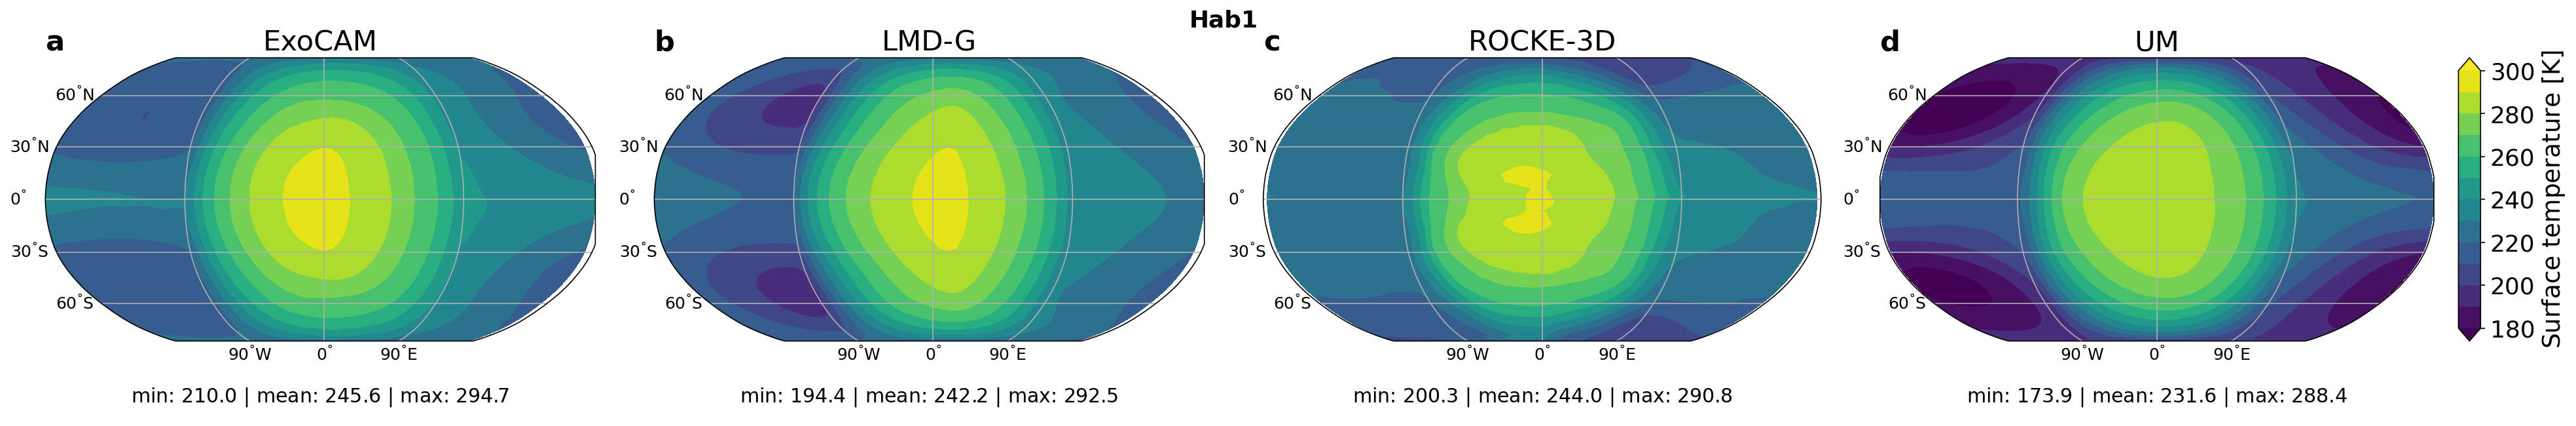

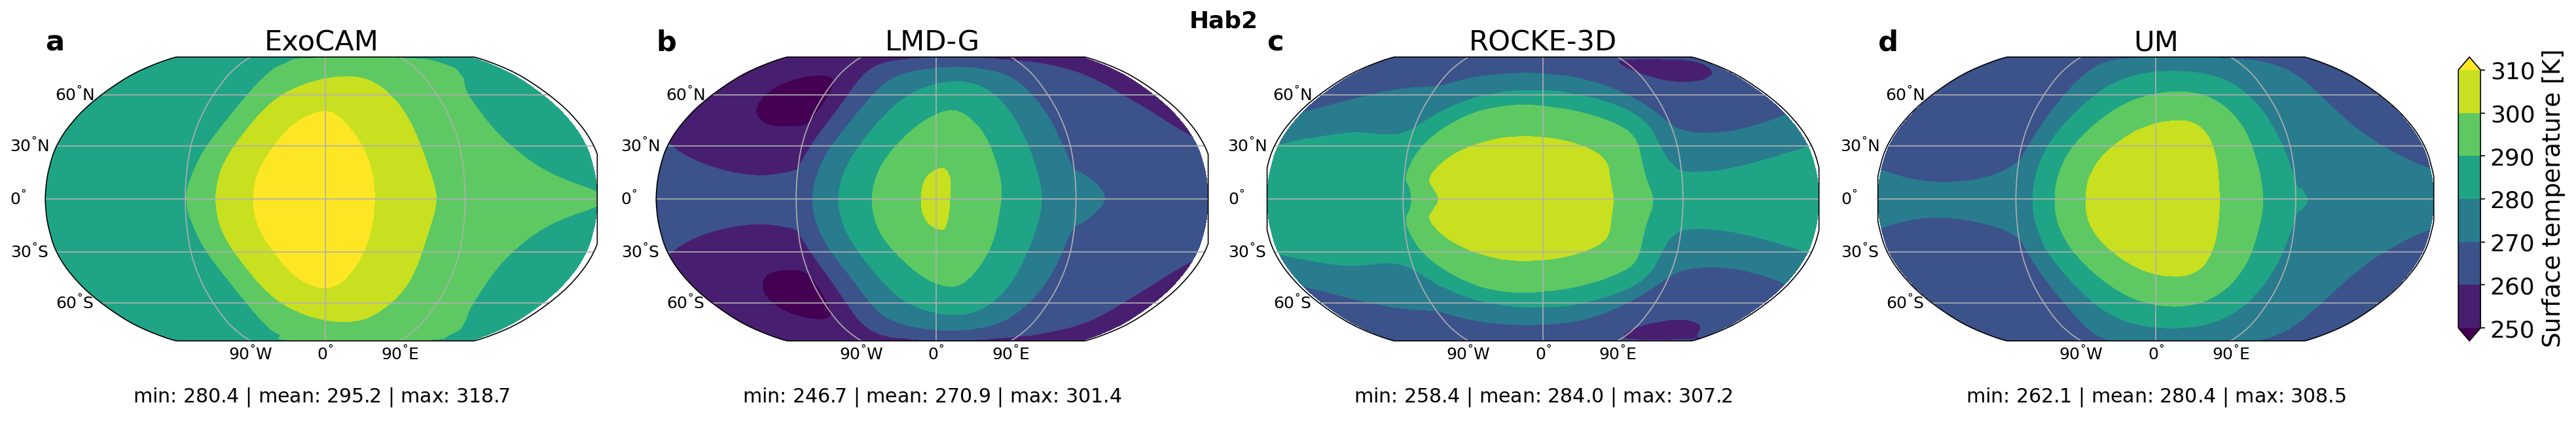

In [8]:
for THAI_case in THAI_cases:
    if THAI_case.endswith("1"):
        import const_ben1_hab1 as const
    else:
        import const_ben2_hab2 as const

    ncols = len(MODELS)
    nrows = len(VARIABLES)

    fig, axgr = make_map_figure(
        ncols,
        nrows,
        axes_pad=(0.6, 0.975),
        cbar_location="right",
        cbar_mode="edge",
        cbar_pad=0.25,
        cbar_size="4%",
        label_mode="",
    )

    for ivar, ((varkey, vardict), axrow, cax) in enumerate(
        zip(VARIABLES.items(), axgr.axes_row, axgr.cbar_axes)
    ):
        for model_key, ax in zip(MODELS.keys(), axrow):
            model_names = names[model_key]
            if ivar == 0:
                ax.set_title(MODELS[model_key]["title"], **KW_MAIN_TTL)
            arr = vardict["func"](datasets[THAI_case][model_key], model_key, const)
            h = draw_scalar(
                arr,
                ax,
                method=vardict["method"],
                cbar_ticks=None,
                use_cyclic=False,
                model_names=model_names,
                **vardict["kw_plt"][THAI_case],
            )
            ax.add_artist(
                AnchoredText(
                    darr_stats_string(
                        arr,
                        model_names.x,
                        model_names.y,
                        eq_sign=": ",
                        fmt="pretty",
                        **vardict["kw_unit_format"],
                    ),
                    loc="lower center",
                    frameon=False,
                    bbox_to_anchor=(0.5, -0.30),
                    bbox_transform=ax.transAxes,
                    prop={
                        "backgroundcolor": "white",
                        "color": "black",
                        "size": "large",
                    },
                )
            )
        cb = fig.colorbar(h, cax=cax, orientation="vertical")
        cb.set_label(f"{vardict['title']} [{vardict['tex_units']}]")
        cb.ax.tick_params(labelsize="x-large")
    fig.suptitle(
        f"{THAI_case}",
        y=0.985,
        fontweight="bold",
        fontsize="x-large",
    )
    # break
    figsave(
        fig,
        mypaths.plotdir / f"{THAI_case}__yx__{'_'.join(VARIABLES.keys())}",
    )